<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/p4m_eqnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
pip install pennylane

In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom

## data mnist 16x16

This worth due to 16*16 = 512 and if we use amplitude embedding then we can use 8 qubits, 2^8 = 512.

# PCA. ANGLE EMBEDDING

https://arxiv.org/pdf/2310.02323

## data mnist 8x1. PCA

In [56]:
# Cargar el conjunto de datos MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtrar los datos de entrenamiento para incluir solo los dígitos 0, 1 y 8
train_filter = np.isin(y_train, [0, 1])#, 8])
X_train_filtered = X_train[train_filter]
y_train_filtered = y_train[train_filter]
X_train_filtered = X_train_filtered[:100]
y_train_filtered = y_train_filtered[:100]

# Filtrar los datos de prueba para incluir solo los dígitos 0, 1 y 8
test_filter = np.isin(y_test, [0, 1])#, 8])
X_test_filtered = X_test[test_filter]
y_test_filtered = y_test[test_filter]
X_test_filtered = X_test_filtered[:100]
y_test_filtered = y_test_filtered[:100]
# Imprimir las formas de los conjuntos de datos filtrados
print(f"X_train_filtered shape: {X_train_filtered.shape}")
print(f"y_train_filtered shape: {y_train_filtered.shape}")
print(f"X_test_filtered shape: {X_test_filtered.shape}")
print(f"y_test_filtered shape: {y_test_filtered.shape}")

# Aplanar las imágenes para que sean vectores en lugar de matrices
X_train_flattened = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flattened = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Normalizar los datos
#scaler = StandardScaler()
#X_train_normalized = scaler.fit_transform(X_train_flattened)
#X_test_normalized = scaler.transform(X_test_flattened)

# Aplicar PCA para reducir la dimensionalidad a 8 componentes principales
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

# Normalizar los datos
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Imprimir las formas de los datos transformados
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")




X_train_filtered shape: (100, 28, 28)
y_train_filtered shape: (100,)
X_test_filtered shape: (100, 28, 28)
y_test_filtered shape: (100,)
X_train_pca shape: (100, 8)
X_test_pca shape: (100, 8)


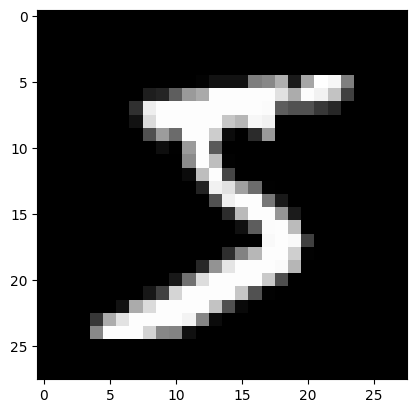

In [41]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [57]:
X_train_pca[0]

array([ 1.07199218,  0.85626172, -0.53966523, -1.48104   ,  0.62373916,
       -0.32973309,  1.06170366,  0.09479658])

ANGLE EMBEDDING

## Equivariant Ansatz




In [42]:
import random
def equiv_ansatz_block(wires, params = [random.random() for _ in range(6)]):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RX(params[3], wires=wires[0])
    qml.RX(params[4], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def equiv_ansatz_block_blue(wires, params = [random.random() for _ in range(3)]):
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])

    qml.RX(params[6], wires=wires[2])
    qml.RX(params[7], wires=wires[3])

    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(params[8], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])

def pooling_layer(wires):
    qml.CY(wires=[wires[0], wires[1]])

## utilities

In [25]:
# Define output labels as quantum state vectors
def density_matrix(state):
    return state * np.conj(state).T

def cost(params, x, y, state_labels=None):
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = eqnn(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: eqnn(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## EQNN

(<Figure size 6900x900 with 1 Axes>, <Axes: >)

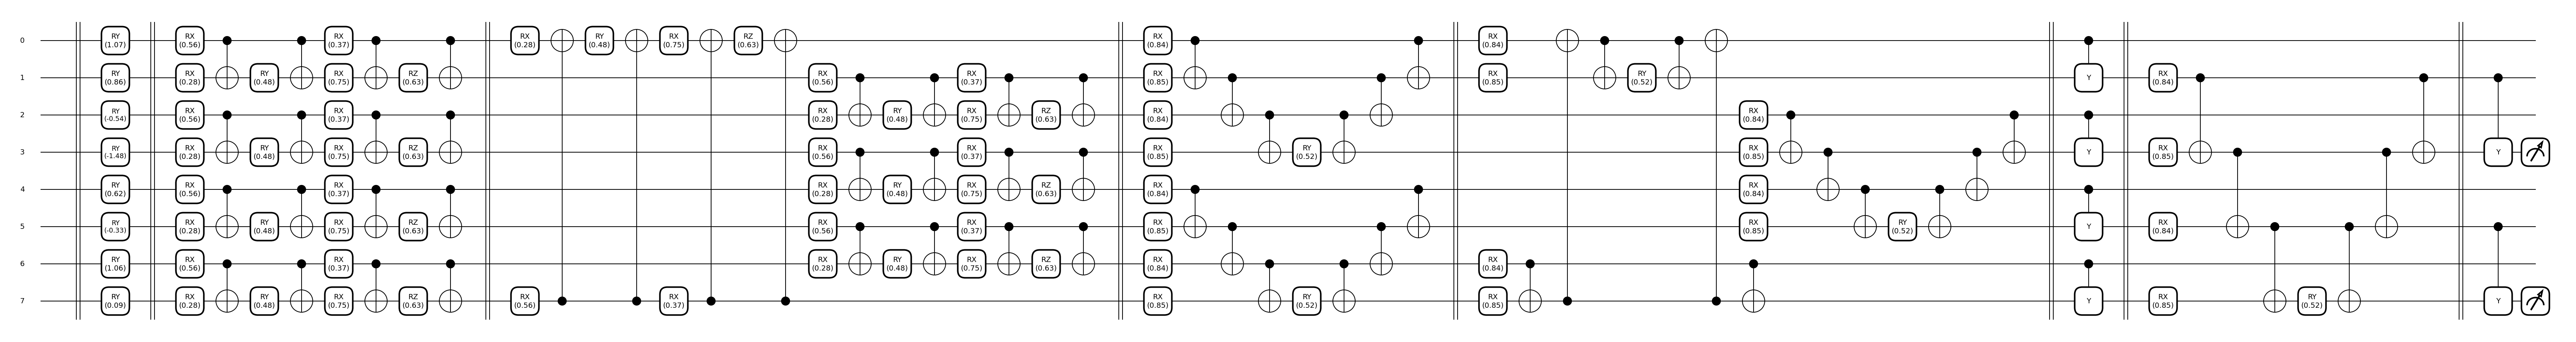

In [49]:
n=8
dev = qml.device("default.qubit", wires=n)
@qml.qnode(dev)

def eqnn(params,x,y):

  ## ANGLE EMBEDDING
  qml.Barrier(wires=range(n))

  for i in range(n):
    qml.RY(x[i], wires = i)

  ## ANSATZ
  qml.Barrier(wires=range(n))
  for i in range( int(n/2)):
    equiv_ansatz_block(wires=[2*i, 2*i+1], params = params)
  qml.Barrier(wires=range(n))

  equiv_ansatz_block(wires=[7, 0], params = params)
  equiv_ansatz_block(wires=[1, 2], params = params)
  equiv_ansatz_block(wires=[3, 4], params = params)
  equiv_ansatz_block(wires=[5, 6], params = params)
  qml.Barrier(wires=range(n))

  # blue block normal
  equiv_ansatz_block_blue(wires=[0, 1, 2, 3], params = params)
  equiv_ansatz_block_blue(wires=[4, 5, 6, 7], params = params)
  qml.Barrier(wires=range(n))

  ##  blue block intercalate
  equiv_ansatz_block_blue(wires=[6, 7, 0, 1], params = params)
  equiv_ansatz_block_blue(wires=[2, 3, 4, 5], params = params)
  qml.Barrier(wires=range(n))

  ## POOLING
  pooling_layer(wires=[0, 1])
  pooling_layer(wires=[2, 3])
  pooling_layer(wires=[4, 5])
  pooling_layer(wires=[6, 7])
  qml.Barrier(wires=range(n))

  ## last block
  equiv_ansatz_block_blue(wires=[1, 3, 5, 7], params = params)
  qml.Barrier(wires=range(n))

  # last pooling
  pooling_layer(wires = [1,3])
  pooling_layer(wires = [5,7])
  return qml.expval(qml.Hermitian(y, wires=[3,7]))

params = [random.random() for _ in range(9)]
x = X_train_pca[0]
y =  density_matrix(state_labels[1])

qml.draw_mpl(eqnn, decimals = 2)(params, x, y)

## TESTING

In [58]:
eqnn(params,x,y)

tensor([0.2896296], requires_grad=True)

In [59]:
x_rotated = X_train_pca[0] +np.pi/2
eqnn(params,x_rotated,y)

tensor([0.25740554], requires_grad=True)

In [66]:
label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2

# Train using Adam optimizer and evaluate the classifier
num_layers = 1
learning_rate = 0.1
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(9,1), requires_grad=True)

predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
accuracy_train = accuracy_score(y_train_filtered, predicted_train)

predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
accuracy_test = accuracy_score(y_test_filtered, predicted_test)


# save predictions with random weights for comparison
initial_predictions = predicted_test


loss = cost(params, X_test_pca, y_test_filtered, state_labels)


best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train_pca, y_train_filtered, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
    accuracy_train = accuracy_score(y_train_filtered, predicted_train)
    loss = cost(params, X_train_pca, y_train_filtered, state_labels)

    predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
    accuracy_test = accuracy_score(y_test_filtered, predicted_test)
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(f"Epoch: {1+it} | Loss: {loss} | Train accuracy: {accuracy_train} | Test accuracy: {accuracy_test}")

Epoch: 1 | Loss: [0.5033571] | Train accuracy: 0.77 | Test accuracy: 0.83
Epoch: 2 | Loss: [0.46008226] | Train accuracy: 0.78 | Test accuracy: 0.83
Epoch: 3 | Loss: [0.4601446] | Train accuracy: 0.79 | Test accuracy: 0.79
Epoch: 4 | Loss: [0.44506851] | Train accuracy: 0.81 | Test accuracy: 0.82
Epoch: 5 | Loss: [0.4394945] | Train accuracy: 0.8 | Test accuracy: 0.83
Epoch: 6 | Loss: [0.42957395] | Train accuracy: 0.79 | Test accuracy: 0.83
Epoch: 7 | Loss: [0.42928108] | Train accuracy: 0.78 | Test accuracy: 0.82
Epoch: 8 | Loss: [0.42167701] | Train accuracy: 0.81 | Test accuracy: 0.81
Epoch: 9 | Loss: [0.4177671] | Train accuracy: 0.82 | Test accuracy: 0.84
Epoch: 10 | Loss: [0.41556977] | Train accuracy: 0.81 | Test accuracy: 0.84


In [68]:
best_params

tensor([[ 1.71215936],
        [ 0.28938312],
        [-0.08470355],
        [ 0.94526385],
        [ 0.49948562],
        [ 0.62325023],
        [ 1.34749141],
        [ 0.5429907 ],
        [ 0.40384619]], requires_grad=True)

best_params = tensor([[ 1.71215936],
        [ 0.28938312],
        [-0.08470355],
        [ 0.94526385],
        [ 0.49948562],
        [ 0.62325023],
        [ 1.34749141],
        [ 0.5429907 ],
        [ 0.40384619]], requires_grad=True)

In [76]:
dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev)
def eqnn(params, x, y):
  qml.AngleEmbedding(x, wires=range(8))
  qml.StronglyEntanglingLayers(params, wires = range(8))
  pooling_layer(wires=[0, 1])
  pooling_layer(wires=[2, 3])
  pooling_layer(wires=[4, 5])
  pooling_layer(wires=[6, 7])
  qml.Barrier(wires=range(8))

  ## last block
  qml.Barrier(wires=range(8))

  # last pooling
  pooling_layer(wires = [1,3])
  pooling_layer(wires = [5,7])
  return qml.expval(qml.Hermitian(y, wires=[3,7]))

label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2

# Train using Adam optimizer and evaluate the classifier
num_layers = 1
learning_rate = 0.1
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9)

# initialize random weights
params = np.random.uniform(size=(1,8,3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
accuracy_train = accuracy_score(y_train_filtered, predicted_train)

predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
accuracy_test = accuracy_score(y_test_filtered, predicted_test)


# save predictions with random weights for comparison
initial_predictions = predicted_test


loss = cost(params, X_test_pca, y_test_filtered, state_labels)


best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train_pca, y_train_filtered, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
    accuracy_train = accuracy_score(y_train_filtered, predicted_train)
    loss = cost(params, X_train_pca, y_train_filtered, state_labels)

    predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
    accuracy_test = accuracy_score(y_test_filtered, predicted_test)
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(f"Epoch: {1+it} | Loss: {loss} | Train accuracy: {accuracy_train} | Test accuracy: {accuracy_test}")

Epoch: 1 | Loss: 0.5484325690163463 | Train accuracy: 0.57 | Test accuracy: 0.64
Epoch: 2 | Loss: 0.5377782819692616 | Train accuracy: 0.72 | Test accuracy: 0.77
Epoch: 3 | Loss: 0.525709306242362 | Train accuracy: 0.71 | Test accuracy: 0.75
Epoch: 4 | Loss: 0.5125486969962266 | Train accuracy: 0.63 | Test accuracy: 0.73
Epoch: 5 | Loss: 0.50108262554089 | Train accuracy: 0.66 | Test accuracy: 0.68
Epoch: 6 | Loss: 0.4976919860027342 | Train accuracy: 0.67 | Test accuracy: 0.7
Epoch: 7 | Loss: 0.4962301498906016 | Train accuracy: 0.69 | Test accuracy: 0.69
Epoch: 8 | Loss: 0.4955705212636403 | Train accuracy: 0.69 | Test accuracy: 0.68
Epoch: 9 | Loss: 0.4950172014907106 | Train accuracy: 0.69 | Test accuracy: 0.72
Epoch: 10 | Loss: 0.4940454892487363 | Train accuracy: 0.68 | Test accuracy: 0.73


# AMPLITUD EMBEDDING

X_train_resized shape: (18516, 16, 16)
X_test_resized shape: (3089, 16, 16)


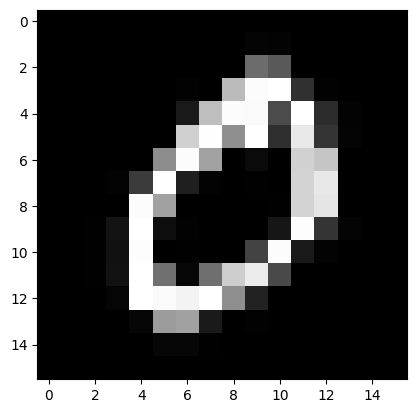

In [12]:
# Función para reducir el tamaño de las imágenes
def resize_images(images, new_size=(16, 16)):
    resized_images = np.array([zoom(image, (new_size[0] / image.shape[0], new_size[1] / image.shape[1])) for image in images])
    return resized_images

# Cargar el conjunto de datos MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtrar los datos de entrenamiento para incluir solo los dígitos 0, 1 y 8
train_filter = np.isin(y_train, [0, 1])#, 8])
X_train_filtered = X_train[train_filter]
y_train_filtered = y_train[train_filter]

# Filtrar los datos de prueba para incluir solo los dígitos 0, 1 y 8
test_filter = np.isin(y_test, [0, 1, 8])
X_test_filtered = X_test[test_filter]
y_test_filtered = y_test[test_filter]

# Reducir el tamaño de las imágenes a 16x16
X_train_resized = resize_images(X_train_filtered, new_size=(16, 16))
X_test_resized = resize_images(X_test_filtered, new_size=(16, 16))

# Imprimir las formas de los conjuntos de datos redimensionados
print(f"X_train_resized shape: {X_train_resized.shape}")
print(f"X_test_resized shape: {X_test_resized.shape}")

plt.imshow(X_train_resized[0], cmap='gray')
plt.show()

In [13]:
# Aplanar las imágenes para que sean vectores en lugar de matrices
X_train_flattened = X_train_resized.reshape(X_train_resized.shape[0], -1)
X_test_flattened = X_test_resized.reshape(X_test_resized.shape[0], -1)
X_train_flattened[0].shape

(256,)

(<Figure size 6900x900 with 1 Axes>, <Axes: >)

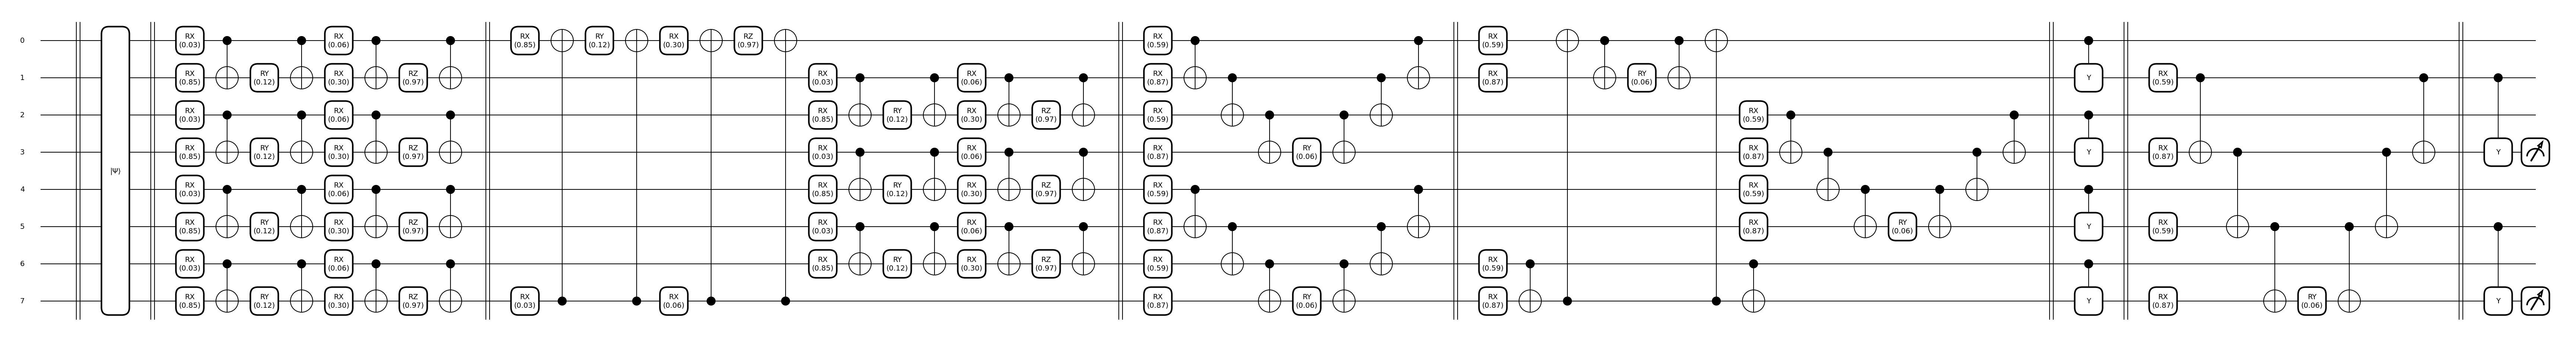

In [14]:
n= 8
dev = qml.device('default.qubit', wires=n)

def eqnn(params,x,y):

  ## EMBEDDING
  qml.Barrier(wires=range(n))

  qml.AmplitudeEmbedding(features=x, wires=range(n), normalize=True)

  ## ANSATZ
  qml.Barrier(wires=range(n))
  for i in range( int(n/2)):
    equiv_ansatz_block(wires=[2*i, 2*i+1])
  qml.Barrier(wires=range(n))

  equiv_ansatz_block(wires=[7, 0])
  equiv_ansatz_block(wires=[1, 2])
  equiv_ansatz_block(wires=[3, 4])
  equiv_ansatz_block(wires=[5, 6])
  qml.Barrier(wires=range(n))

  # blue block normal
  equiv_ansatz_block_blue(wires=[0, 1, 2, 3])
  equiv_ansatz_block_blue(wires=[4, 5, 6, 7])
  qml.Barrier(wires=range(n))

  ##  blue block intercalate
  equiv_ansatz_block_blue(wires=[6, 7, 0, 1])
  equiv_ansatz_block_blue(wires=[2, 3, 4, 5])
  qml.Barrier(wires=range(n))

  ## POOLING
  pooling_layer(wires=[0, 1])
  pooling_layer(wires=[2, 3])
  pooling_layer(wires=[4, 5])
  pooling_layer(wires=[6, 7])
  qml.Barrier(wires=range(n))

  ## last block
  equiv_ansatz_block_blue(wires=[1, 3, 5, 7])
  qml.Barrier(wires=range(n))

  # last pooling
  pooling_layer(wires = [1,3])
  pooling_layer(wires = [5,7])
  return qml.expval(qml.Hermitian(y, wires=[3,7]))

params = [random.random() for _ in range(3)]
x = X_train_flattened[0]
y =  density_matrix(state_labels[1])

qml.draw_mpl(eqnn, decimals = 2)(params, x, y)

In [15]:
print(eqnn(params,x,y))

expval(Hermitian(tensor([[ 0.25, -0.25, -0.25,  0.25],
        [-0.25,  0.25,  0.25, -0.25],
        [-0.25,  0.25,  0.25, -0.25],
        [ 0.25, -0.25, -0.25,  0.25]], requires_grad=False), wires=[3, 7]))


In [17]:
label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2

# Train using Adam optimizer and evaluate the classifier
num_layers = 1
learning_rate = 0.1
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(9,1), requires_grad=True)

predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
accuracy_train = accuracy_score(y_train_filtered, predicted_train)

predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
accuracy_test = accuracy_score(y_test_filtered, predicted_test)


# save predictions with random weights for comparison
initial_predictions = predicted_test


loss = cost(params, X_test_pca, y_test_filtered, state_labels)


best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train_pca, y_train_filtered, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train_pca, y_train_filtered, state_labels)
    accuracy_train = accuracy_score(y_train_filtered, predicted_train)
    loss = cost(params, X_train_pca, y_train_filtered, state_labels)

    predicted_test, fidel_test = test(params, X_test_pca, y_test_filtered, state_labels)
    accuracy_test = accuracy_score(y_test_filtered, predicted_test)
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(f"Epoch: {1+it} | Loss: {loss} | Train accuracy: {accuracy_train} | Test accuracy: {accuracy_test}")

NameError: name 'qcircuit' is not defined

# REFLECTION EQNN


https://arxiv.org/pdf/2212.00264